In [1]:
import sys
import os
import glob
import pandas as pd

import numpy as np
import sklearn
print (sklearn.__version__)

from sklearn import linear_model
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.externals import joblib

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.svm import  SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.externals.six import StringIO

from sklearn.ensemble import RandomForestClassifier

0.19.1


In [2]:
# ディレクトリ名
input_dir = ur"C:/Users/mirait/wk/git/input/"
output_dir = ur"C:/Users/mirait/wk/git/output/"

In [3]:
# 訓練データを読み込む
train_path = input_dir + ur"train.csv"
train_data = pd.read_csv(train_path, encoding="cp932",low_memory=False)
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# テストデータを読み込む
test_path = input_dir + ur"test.csv"
test_data = pd.read_csv(test_path, encoding="cp932",low_memory=False)
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
print "訓練データ：レコード長", len(train_data)
print "訓練データ：カラム数",len(train_data.columns)
print "テストデータ：レコード長", len(test_data)
print "テストデータ：カラム数",len(test_data.columns)

訓練データ：レコード長 891
訓練データ：カラム数 12
テストデータ：レコード長 418
テストデータ：カラム数 11


In [6]:
# 分析に生かすために項目の特徴量を取得
def feature(df):
    
    df_feature = pd.DataFrame()
    
    for i in (range(len(df.columns))):
        tmp = pd.DataFrame()
        tmp = df.iloc[:, [i]]
        
        selList = list()
        record_cn = len(tmp) #レコード数
        column_name = tmp.columns[0] #カラム名
        value_type_cn = len(pd.value_counts(tmp.values.flatten())) #値の種類数(NAはカウント外)
        NA_cn = tmp.isnull().sum().values[0] #NA件数

        feature_list = list([record_cn, column_name, value_type_cn, NA_cn])
        now_column = pd.DataFrame(feature_list).T
        #print res1
        
        df_feature = pd.concat([df_feature, now_column], ignore_index=True)
    
    df_feature.columns = [u'レコード数', u'カラム名', 'v_count', u'NA件数']
        
    col_names = list(df_feature.columns)
    df_feature = df_feature.loc[:, col_names]

    return df_feature

In [7]:
# 訓練データの特徴量
feature_train = feature(train_data)
print len(feature_train)

12


In [8]:
# テストデータの特徴量
feature_test = feature(test_data)
print len(feature_test)

11


In [9]:
output_feature_train = os.path.join(output_dir, "column_feature_train.csv")
feature_train.to_csv(output_feature_train, encoding="cp932",index=False)

In [10]:
output_feature_test = os.path.join(output_dir, "column_feature_test.csv")
feature_test.to_csv(output_feature_test, encoding="cp932",index=False)

In [11]:
# データ型が定義されているファイルを読み込み　（データ型は独自判断）
type_list = input_dir + ur"type_list.csv"
df_type = pd.read_csv(type_list, encoding="cp932", low_memory=False)

In [12]:
df_type

,column_name,type
0,PassengerId,char
1,Survived,char
2,Pclass,char
3,Name,char
4,Sex,char
5,Age,number
6,SibSp,number
7,Parch,number
8,Ticket,char
9,Fare,number


In [13]:
type_char = df_type.query('type == "char"')
char_type_column = set(list(type_char["column_name"]))
train_char = train_data.loc[:, char_type_column]

In [14]:
# 値の種類数が100以上の項目は除外対象とする　（カテゴリ項目のみ）
over_value100_list = list(feature_train.query("v_count >= 100")[u"カラム名"].values)

In [15]:
# カテゴリ項目を抽出し除外
char_column = list(train_char.columns)
del_char = list(set(char_column) & set(over_value100_list))
wk_set = set(list(train_data.columns)) - set(del_char)
wk_sel = list(wk_set)
clean_train = train_data.loc[:, wk_sel]

In [16]:
print clean_train.head()
print clean_train.columns

      Fare Embarked   Age  Parch  Pclass     Sex  Survived  SibSp
0   7.2500        S  22.0      0       3    male         0      1
1  71.2833        C  38.0      0       1  female         1      1
2   7.9250        S  26.0      0       3  female         1      0
3  53.1000        S  35.0      0       1  female         1      1
4   8.0500        S  35.0      0       3    male         0      0
Index([u'Fare', u'Embarked', u'Age', u'Parch', u'Pclass', u'Sex', u'Survived',
       u'SibSp'],
      dtype='object')


In [17]:
# 文字列（Embarked）の最頻値を抽出するのは実装上困難なため、replaceで代替
pd.value_counts(clean_train["Embarked"]) # "S"
clean_train["Embarked"] = clean_train["Embarked"].replace([np.nan],"S")

In [18]:
# 欠損値が存在する項目（Age）は平均値で置換
clean_train["Age"] = clean_train["Age"].fillna(clean_train["Age"].mean())

In [19]:
# 欠損値が存在しないことを確認
print clean_train.isnull().any(axis=0)

Fare        False
Embarked    False
Age         False
Parch       False
Pclass      False
Sex         False
Survived    False
SibSp       False
dtype: bool


In [20]:
# モデル構築

In [21]:
# SGD

In [22]:
# 目的変数"Survived"がダミー変数化対象になるため退避
target = clean_train["Survived"]
clean_train_wk = clean_train.drop(columns = {"Survived"},axis =1)

In [23]:
# 目的変数の値を確認
print "値0", len(clean_train.query('Survived == 0'))
print "値1", len(clean_train.query('Survived == 1'))

値0 549
値1 342


In [24]:
# カテゴリ項目を抽出
clean_train_column = set(list(clean_train_wk.columns))
char_column = set(list(type_char["column_name"]))
char_match_lis2 = list(clean_train_column & char_column)
print "入力ファイルの項目数　：　CHAR型の項目数　：", len(clean_train_wk.columns), "：", len(char_match_lis2)
char_column_lis2 = clean_train_wk.loc[:,char_match_lis2]

入力ファイルの項目数　：　CHAR型の項目数　： 7 ： 3


In [25]:
# 数値項目を抽出
type_num = df_type.query('type == "number"')
num_type_column = set(list(type_num["column_name"]))
train_num = clean_train_wk.loc[:, num_type_column]

In [26]:
char_ex = char_column_lis2.astype('unicode')
# フラグ値ではないため先頭値は削除しない
char_ex_dum = pd.get_dummies(char_ex, drop_first=False)

In [27]:
# 目的変数を結合 (分割前に同じdfになければ、indexがずれるのでマージ前に結合しておく)
wk = pd.concat([char_ex_dum,target], axis=1)
# マージ
merge_file = pd.concat([train_num,wk], axis=1)

In [28]:
print len(merge_file)
print len(merge_file.columns)
print merge_file.head()

891
13
      Fare   Age  SibSp  Parch  Sex_female  Sex_male  Pclass_1  Pclass_2  \
0   7.2500  22.0      1      0           0         1         0         0   
1  71.2833  38.0      1      0           1         0         1         0   
2   7.9250  26.0      0      0           1         0         0         0   
3  53.1000  35.0      1      0           1         0         1         0   
4   8.0500  35.0      0      0           0         1         0         0   

   Pclass_3  Embarked_C  Embarked_Q  Embarked_S  Survived  
0         1           0           0           1         0  
1         0           1           0           0         1  
2         1           0           0           1         1  
3         0           0           0           1         1  
4         1           0           0           1         0  


In [29]:
# 欠損値の処理
tmp = merge_file.copy()
print len(tmp)
tmp01 = tmp.dropna()
print len(tmp01),":NA行数 ",(len(tmp)-len(tmp01))
tmp02 = tmp01.replace([np.inf,-np.inf],np.nan)    #infの置換
tmp03 = tmp02.dropna().reset_index(drop =True)
print len(tmp03),":inf行数 ",(len(tmp02)-len(tmp03))

891
891 :NA行数  0
891 :inf行数  0


In [30]:
# 説明変数、目的変数への分割
X = tmp04.drop(columns = {u"Survived"},axis =1)
y = tmp04.loc[:,[u"Survived"]]

print len(X.columns)
print len(X)

12
891


In [31]:
# データ分割
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.3, random_state=0)

In [32]:
# 数値項目の標準化のため、カラム単位でデータ型を分離
X_column = list(X.columns)
num_column = set(list(train_num.columns))
char_column = set(X_column) - set(num_column)

In [33]:
# 数値項目において訓練データの平均値/標準偏差から訓練データ、テストデータのz-scoreを算出し標準化する
# StandardScalerは上記が実現不可のため個別実装
def number_scaler(X_train, X_test):
    
    train_scaler = pd.DataFrame()
    test_scaler = pd.DataFrame()
    train_std = pd.DataFrame()
    
    train_num = X_train.loc[:, num_column]
    test_num = X_test.loc[:, num_column]
    
    # 標準化後にカテゴリ項目をマージさせるために定義
    train_char = X_train.loc[:, char_column]
    test_char = X_test.loc[:, char_column]
    
    # 標準偏差を詰めるリスト
    std_lis =[]
    
    # 訓練データの平均値、標準偏差を取得
    for i in train_num.columns:        
        train_mean = train_num[i].mean()
        train_std = train_num[i].std()
        
        # z-scoreを求める
        train_z = pd.DataFrame({i:(train_num[i] - train_mean) / train_std})
        test_z = pd.DataFrame({i:(test_num[i] - train_mean) / train_std})
        # 訓練データの標準偏差を詰める
        std_lis.append(train_std) 
        
        train_scaler = pd.concat([train_scaler, train_z], axis=1)
        test_scaler = pd.concat([test_scaler, test_z], axis=1)
    
    # カテゴリ項目をマージ
    train_scaler = pd.concat([train_scaler,train_char], axis=1)
    test_scaler = pd.concat([test_scaler,test_char], axis=1)
    
    # 訓練データの分割次第では標準偏差が0となり、z-scoreが'Nan'となるため0埋めする
    train_scaler = train_scaler.fillna(0)
    test_scaler = test_scaler.fillna(0)
    
    # 項目の標準偏差を出力
    train_std = pd.DataFrame(std_lis).T
    train_std.columns = num_column
    train_std= train_std.T.reset_index(drop=False)
    train_std.columns =["col_name","std"]
    
    print "train:",len(train_scaler)
    print "test:",len(test_scaler)

    return train_scaler, test_scaler, train_std 

In [34]:
# グリッドサーチ
def grid(x, y, sc_list, clf, grid_param, cv):
    
    # パラメータ探索
    score = sc_list[0]
    gs = GridSearchCV(clf, grid_param, cv=cv, scoring=score)
    gs.fit(x, y)
    
    # グリッドサーチの結果を出力
    result = pd.DataFrame(gs.grid_scores_)
    result = result.rename(columns={'mean_validation_score':score})
    result = result.iloc[:,[0,1]]
    print gs.best_params_
    
    for i in sc_list[1:]:
        score = i
        gs = GridSearchCV(clf, grid_param, cv=cv, scoring=score)
        gs.fit(x, y)
        res = pd.DataFrame(gs.grid_scores_)
        res = res.rename(columns={'mean_validation_score':score})
        res = res.iloc[:,[1]]
        result = pd.concat([result,res],axis=1)
    
    return result, gs.best_params_

In [35]:
# SGD (回帰係数、適合率など評価)
def sgd(X_train, y_train, X_test, y_test, param, X_std):
    
    # モデル構築
    clf =linear_model.SGDClassifier(loss='log', penalty='elasticnet', random_state=0, class_weight='balanced',
                                    alpha = param['alpha'] , l1_ratio = param['l1_ratio'], max_iter=500)
    clf.fit(X_train,y_train)
    
    # モデル評価を出力
    print "score:", clf.score(X_test,y_test)
    print "confusion_matrix:"
    print confusion_matrix(y_test, clf.predict(X_test))

    # 回帰係数を出力
    coeff_df = pd.DataFrame([X_train.columns,  clf.coef_[0]]).T
    coeff_df.columns = ["col_name","coef"] 
    coeff_df["coef_abs"] = abs(coeff_df["coef"] )
    coeff_sort = coeff_df.sort_values(by="coef_abs", ascending=False).reset_index(drop=True)
    # 回帰係数+標準偏差でマージ
    coeff_merge = pd.merge(coeff_sort, X_std, on="col_name", how="left")
    coeff_merge["coef/std"] = coeff_merge["coef"]/coeff_merge["std"]
    
    for i in range(len(coeff_merge)):
        if np.isnan(coeff_merge.loc[i,"coef/std"]) == True:
            coeff_merge.loc[i,"coef/std"] = coeff_merge.loc[i,"coef"]
        else:
            pass

    print ""
    print "回帰係数の総数",len(coeff_sort)
    coeff_sort.coef =coeff_sort.coef.astype(np.float)
    print "回帰係数 0の数",len(coeff_sort.query('coef == 0'))
    print "回帰係数 0以外の数",len(coeff_sort.query('coef != 0'))
    

    # 適合率、再現率、閾値をそれぞれ出力
    print ""
    precision, recall, threshold = precision_recall_curve(y_test, clf.predict_proba(X_test)[:,1] )#

#     print "precision ",precision
#     print "recall_",recall
#     print "threshold",threshold
    
    print ""
    print (sklearn.metrics.classification_report(y_test, clf.predict(X_test)))
    
    print ""
    prob = clf.predict_proba(X_test)[:,1]
    fpr,tpr,thresholds = sklearn.metrics.roc_curve(y_test,prob)
    print "auc", round(sklearn.metrics.auc(fpr,tpr),4)
    
    # ROC曲線
    plt.plot(fpr, tpr)
    plt.title("ROC curve")
    plt.xlabel("False Positve Rate")
    plt.ylabel("True Positive Rate")
    #plt.show()
    
    return clf, coeff_sort, coeff_merge

In [36]:
# 数値項目を標準化
X_train_scaler, X_test_scaler, X_train_std = number_scaler(X_train, X_test)

train: 623
test: 268


In [37]:
# テストデータの欠損値を削除した上で目的変数に欠損値が存在しない行を指定する
X_test_scaler = (X_test_scaler.replace([np.inf,-np.inf],np.nan)).dropna()
noinf_ix = list(X_test_scaler.index)
y_test = y_test.loc[noinf_ix,:]

In [38]:
print X_train_scaler.columns

Index([u'Fare', u'Age', u'SibSp', u'Parch', u'Pclass_1', u'Embarked_Q',
       u'Pclass_3', u'Pclass_2', u'Sex_male', u'Sex_female', u'Embarked_S',
       u'Embarked_C'],
      dtype='object')


In [39]:
# モデルの評価値
#sc_list = ['roc_auc','accuracy','f1']
sc_list = ['accuracy']
# 交差検定の実行回数
cv  = 10

In [40]:
# SGDのパラメータリスト
sgd_param = [{'alpha': [0.009, 0.01, 0.03],'l1_ratio': [0.07, 0.08, 0.09]}]

In [41]:
# グリッドサーチ用SGD
grid_sgd = linear_model.SGDClassifier(loss='log', penalty='elasticnet', random_state=0, class_weight='balanced',max_iter=50)

In [42]:
print grid_sgd

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=50, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=0,
       shuffle=True, tol=None, verbose=0, warm_start=False)


In [43]:
grid_result_SGD, best_param_SGD = grid(X_train_scaler, y_train, sc_list, grid_sgd, sgd_param, cv)

C:\Users\mirait\Anaconda2\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'alpha': 0.01, 'l1_ratio': 0.07}


C:\Users\mirait\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [44]:
# グリッドサーチの探索結果を出力
output_grid = os.path.join(output_dir, "grid_SGD.csv")
grid_result_SGD.to_csv(output_grid, encoding="cp932", index=False)

score: 0.7873134328358209
confusion_matrix:
[[135  33]
 [ 24  76]]


             precision    recall  f1-score   support

          0       0.85      0.80      0.83       168
          1       0.70      0.76      0.73       100

avg / total       0.79      0.79      0.79       268


auc 0.8532


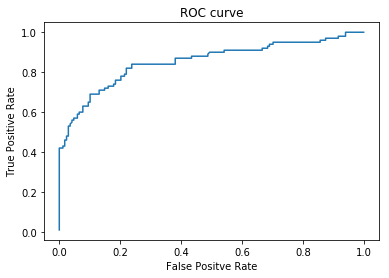

In [45]:
clf_SGD, result ,result_std = sgd(X_train_scaler, y_train, X_test_scaler, y_test, best_param_SGD, X_train_std)

In [46]:
# モデル構築結果を出力
output_path = os.path.join(output_dir, "result_std.csv")
result_std.to_csv(output_path, encoding="cp932", index=False)

In [47]:
# 交差検証
cross_scores = cross_val_score(clf_SGD, X_test_scaler, (np.array(y_test.iloc[:,0].values.flatten())), cv=10)
print cross_scores
print ("Accuracy: %0.2f" % (cross_scores.mean()))

[0.85185185 0.81481481 0.7037037  0.7037037  0.81481481 0.74074074
 0.85185185 0.7037037  0.80769231 0.73076923]
Accuracy: 0.77


In [48]:
# 決定木

In [49]:
def decisionTree (x_train, x_test, y_train, y_test):
    
    # モデル構築
    clf = DecisionTreeClassifier(max_depth=5, random_state=0, class_weight='balanced')
    clf.fit(X_train, y_train)
    
    predicted = clf.predict(x_test)
    #print "識別率：", float(sum(predicted == np.array(y_test.iloc[:,0]).T))/len(y_test)
    dot_data = StringIO()
    tree.export_graphviz(clf, out_file = dot_data, feature_names=list(x_train.columns), filled=True, rounded=True,impurity=False)
    res = dot_data.getvalue()
    res_wk = res.encode("cp932")
    dot_file = res_wk.replace("fontname=helvetica","fontname=meiryo")
    
    print "accuracy_score:", round(clf.score(x_test,y_test),4)
    print "confusion_matrix:"
    print confusion_matrix(y_test,clf.predict(x_test))
    print ""
    prob = clf.predict_proba(x_test)[:,1]
    fpr,tpr,thresholds = roc_curve(y_test,prob)
    print "auc:", round(auc(fpr,tpr),4)
    
    # 変数重要度
    column_importance = pd.DataFrame(clf.feature_importances_).T
    column_importance.columns = list(x_train.columns)
    column_importance_wk = column_importance.T.reset_index(drop=False)
    column_importance_wk.columns = ["col_name","feature_importances"]
    column_importance_sort = column_importance_wk.sort_values(by="feature_importances", ascending=False).reset_index(drop=True)

    return clf, dot_file, column_importance_sort

In [50]:
clf_dt, dot_file, dt_importance = decisionTree(X_train, X_test, y_train, y_test)

accuracy_score: 0.7873
confusion_matrix:
[[128  40]
 [ 17  83]]

auc: 0.8416


In [51]:
#ファイル出力
f = open('decisionTree.dot','w')
f.write(dot_file)
f.close()

In [52]:
# ランダムフォレスト

In [53]:
def randomforest(x_train, x_test, y_train, y_test, param):
    clf = RandomForestClassifier(n_estimators = param['n_estimators'], max_depth = param['max_depth'], 
                                 random_state=0, class_weight='balanced')
    clf.fit(x_train, y_train)
    prob = clf.predict_proba(x_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, prob)
    
    print "acc:",round(clf.score(x_test,y_test),4)
    print "auc:", round(auc(fpr,tpr),4)
    print "confusion_matrix:"
    print confusion_matrix(y_test,clf.predict(x_test))
    
    # ROC曲線を出力
    plt.plot(fpr, tpr)
    plt.title("ROC curve")
    plt.xlabel("False Positve Rate")
    plt.ylabel("True Positive Rate")
    
    return clf

In [54]:
# 特徴量を順位付け
def get_feature_importance(x, clf):
    col_name = pd.DataFrame(x.columns)
    fi = pd.DataFrame(clf.feature_importances_)
    df_wk = pd.concat([col_name, fi],axis=1)
    df_wk.columns = ["col_name","feature_importance"]
    importance_list = df_wk.sort_values(by="feature_importance", ascending=False).reset_index(drop=True)
    
    return importance_list 

In [55]:
# ランダムフォレストのパラメータリスト
depth_range = range(1, 10, 1)
rf_parameter = [{'n_estimators':[5, 10, 100, 150], 'max_depth':depth_range}]

In [56]:
# グリッドサーチ用ランダムフォレスト
grid_rf = RandomForestClassifier(random_state=0, class_weight='balanced')

In [57]:
# パラメータ探索　（標準化の必要がないため、説明変数は標準化前のデータを使用）
grid_result_rf, best_param_rf = grid(X_train, y_train, sc_list, grid_rf, rf_parameter, cv)

C:\Users\mirait\Anaconda2\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mirait\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 100, 'max_depth': 6}


C:\Users\mirait\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [58]:
# グリッドサーチの探索結果を出力
output_grid = os.path.join(output_dir, "grid_rf.csv")
grid_result_rf.to_csv(output_grid, encoding="cp932", index=False)

C:\Users\mirait\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


acc: 0.806
auc: 0.8787
confusion_matrix:
[[143  25]
 [ 27  73]]


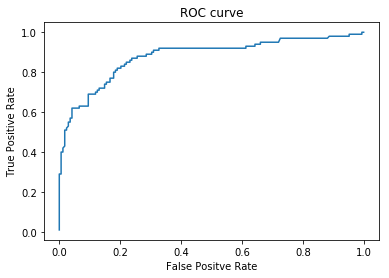

In [59]:
clf_rf = randomforest(X_train, X_test, y_train, y_test, best_param_rf)

In [60]:
# 特徴量の順位を取得
feature_importance = get_feature_importance(X_train, clf_rf)
output_path = os.path.join(output_dir, "feature_importance.csv")
feature_importance.to_csv(output_path, encoding="cp932", index=False)